In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from skimage.util import view_as_windows
from skimage import io, img_as_float
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.decomposition import DictionaryLearning


In [2]:
# load images from grayscale-dataset (dataset used is Flickr1024 and Div2K)

dir = '../medical-images'  # Directory containing images
target_size = (256,256)  # Target size for resizing
images = []
for filename in os.listdir(dir):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        img_path = os.path.join(dir, filename)
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img = img.resize(target_size)  # Resize to fixed shape
        images.append(np.array(img))

# Now all images are same shape
images = np.array(images)
print(f'Loaded {len(images)} images of shape {images[0].shape}')


Loaded 100 images of shape (256, 256)


In [3]:
images.shape

(100, 256, 256)

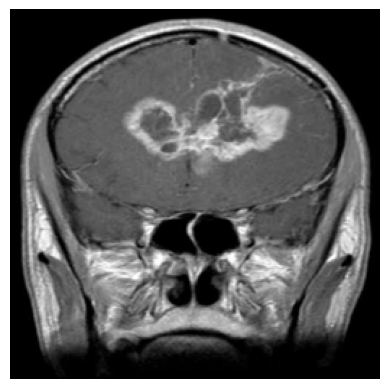

In [4]:
# Display the first image
plt.imshow(images[0], cmap='gray')
plt.axis('off')
plt.show()


Saved images to ../medical-images


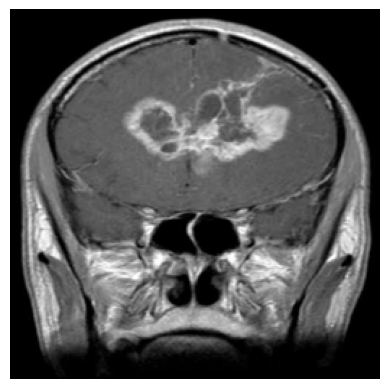

In [5]:
# save grayscale images to a new directory
output_dir = '../medical-images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for i, img in enumerate(images):
    img_pil = Image.fromarray(img.astype(np.uint8))
    img_pil.save(os.path.join(output_dir, f'image_{i}.png'))
print(f'Saved images to {output_dir}')
# Display the first image
plt.imshow(images[0], cmap='gray')
plt.axis('off')
plt.show()

In [51]:
# def add_guassian_noise(img, sigma):
#     """Add Gaussian noise to an image."""
#     noise = np.random.normal(0, sigma, img.shape).astype(np.uint8)
#     noisy_img = np.clip(img + noise, 0, 255).astype(np.uint8)
#     return noisy_img


# # test on first image
# noisy_img = add_guassian_noise(images[0], sigma=20)
# # Display the noisy image
# plt.imshow(noisy_img, cmap='gray')
# plt.axis('off')
# plt.show()

In [52]:
# # save the noisy images for each image in the dataset
# os.makedirs('noisy_dataset', exist_ok=True)  # Create directory if it doesn't exist
# for i, img in enumerate(images):
#     noisy_img = add_guassian_noise(img, sigma=20)
#     noisy_img_path = os.path.join('noisy_dataset', f'noisy_{i}.png')
#     Image.fromarray(noisy_img).save(noisy_img_path)
# print(f'Saved noisy images to "noisy_dataset" directory.')
# # Display the first noisy image 
# plt.imshow(noisy_img, cmap='gray')
# plt.axis('off')
# plt.show()

# DENOISING

![image](DA.png)

In [25]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, rho=0.05, beta=1e-2):
        super().__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.rho = rho
        self.beta = beta

    def forward(self, x):
        h = torch.sigmoid(self.encoder(x))
        out = torch.sigmoid(self.decoder(h))
        return out, h

    def sparsity_loss(self, h):
        rho_hat = h.mean(0)
        rho = torch.full_like(rho_hat, self.rho)
        kl_div = rho * torch.log(rho / (rho_hat + 1e-8)) + \
                 (1 - rho) * torch.log((1 - rho) / (1 - rho_hat + 1e-8))
        return self.beta * kl_div.sum()


class StackedSSDA(nn.Module):
    def __init__(self, input_dim, hidden_dims, rho=0.05, beta=1e-2):
        super().__init__()
        self.dae1 = DenoisingAutoencoder(input_dim, hidden_dims[0], rho, beta)
        self.dae2 = DenoisingAutoencoder(hidden_dims[0], hidden_dims[1], rho, beta)

        self.encoder1 = self.dae1.encoder
        self.encoder2 = self.dae2.encoder
        self.decoder2 = self.dae2.decoder
        self.decoder1 = self.dae1.decoder

    def forward(self, x):
        h1 = torch.sigmoid(self.encoder1(x))
        h2 = torch.sigmoid(self.encoder2(h1))
        out2 = torch.sigmoid(self.decoder2(h2))
        out1 = torch.sigmoid(self.decoder1(out2))
        return out1


In [ ]:
def extract_patches(img, patch_size=16, stride=8):
    patches = view_as_windows(img, (patch_size, patch_size), step=stride)
    patches = patches.reshape(-1, patch_size, patch_size)
    return patches

def add_gaussian_noise(patches, sigma):
    noisy = patches + np.random.normal(0, sigma / 255., patches.shape)
    return np.clip(noisy, 0., 1.)

def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0: return 100
    PIXEL_MAX = 1.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

def load_image(path):
    return img_as_float(io.imread(path, as_gray=True))

def prepare_data(sigma, image_dir="grayscale_images", patch_size=16, stride=8):
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.png'))]
    # only take 500 images for training
    image_paths = image_paths[:500]
    patches, clean_patches = [], []
    for path in image_paths:
        img = load_image(path)
        # noisy_img = add_gaussian_noise(img, sigma)
        ps = extract_patches(img, patch_size, stride)
        # noisy_patches = extract_patches(noisy_img, patch_size, stride)
        noisy = add_gaussian_noise(ps, sigma)
        patches.append(noisy)
        clean_patches.append(ps)

    x = np.concatenate(patches).reshape(-1, patch_size**2)
    y = np.concatenate(clean_patches).reshape(-1, patch_size**2)

    x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    dataset = torch.utils.data.TensorDataset(x, y)
    return torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def pretrain_da(model, dataloader, epochs=15, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            out, h = model(xb)
            loss = criterion(out, yb) + model.sparsity_loss(h)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[Pretrain] Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

def fine_tune(model, dataloader, epochs=25, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[Fine-tune] Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")



In [ ]:
sigma = 50
dataloader = prepare_data(sigma=sigma)
input_dim = 16 * 16
hidden_dims = [512, 256]

dae1 = DenoisingAutoencoder(input_dim, hidden_dims[0]).to(device)
print("Pretraining DAE1...")
pretrain_da(dae1, dataloader)

h1_x, h1_y = [], []
dae1.eval()
for xb, yb in dataloader:
    with torch.no_grad():
        xb, yb = xb.to(device), yb.to(device)
        _, h_x = dae1(xb)
        _, h_y = dae1(yb)
        h1_x.append(h_x.cpu())
        h1_y.append(h_y.cpu())
h1_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.cat(h1_x), torch.cat(h1_y)),
    batch_size=128, shuffle=True
)

dae2 = DenoisingAutoencoder(hidden_dims[0], hidden_dims[1]).to(device)
print("Pretraining DAE2...")
pretrain_da(dae2, h1_loader)

ssda = StackedSSDA(input_dim, hidden_dims).to(device)
ssda.load_state_dict({
    **{f'dae1.{k}': v for k, v in dae1.state_dict().items()},
    **{f'dae2.{k}': v for k, v in dae2.state_dict().items()}
}, strict=False)

os.makedirs("model", exist_ok=True)
fine_tune(ssda, dataloader)
torch.save(ssda.state_dict(), "model/ssda_denoise2.pth")
print("Model saved to model/ssda_denoise2.pth")

In [ ]:
# Pretraining DAE1...
# [Pretrain] Epoch 1/15, Loss: 235.4563
# [Pretrain] Epoch 2/15, Loss: 99.5889
# [Pretrain] Epoch 3/15, Loss: 91.8344
# [Pretrain] Epoch 4/15, Loss: 87.7662
# [Pretrain] Epoch 5/15, Loss: 85.1928
# [Pretrain] Epoch 6/15, Loss: 83.5681
# [Pretrain] Epoch 7/15, Loss: 82.5926
# [Pretrain] Epoch 8/15, Loss: 82.0961
# [Pretrain] Epoch 9/15, Loss: 81.7956
# [Pretrain] Epoch 10/15, Loss: 81.5105
# [Pretrain] Epoch 11/15, Loss: 81.3077
# [Pretrain] Epoch 12/15, Loss: 81.1592
# [Pretrain] Epoch 13/15, Loss: 81.0054
# [Pretrain] Epoch 14/15, Loss: 80.8947
# [Pretrain] Epoch 15/15, Loss: 80.8036
# Pretraining DAE2...
# [Pretrain] Epoch 1/15, Loss: 70.4826
# [Pretrain] Epoch 2/15, Loss: 2.4289
# [Pretrain] Epoch 3/15, Loss: 1.5097
# [Pretrain] Epoch 4/15, Loss: 1.2488
# [Pretrain] Epoch 5/15, Loss: 1.1313
# [Pretrain] Epoch 6/15, Loss: 1.0726
# [Pretrain] Epoch 7/15, Loss: 1.0352
# [Pretrain] Epoch 8/15, Loss: 1.0074
# [Pretrain] Epoch 9/15, Loss: 0.9841
# [Pretrain] Epoch 10/15, Loss: 0.9663
# [Pretrain] Epoch 11/15, Loss: 0.9517
# [Pretrain] Epoch 12/15, Loss: 0.9410
# [Pretrain] Epoch 13/15, Loss: 0.9285
# [Pretrain] Epoch 14/15, Loss: 0.9207
# [Pretrain] Epoch 15/15, Loss: 0.9128
# [Fine-tune] Epoch 1/25, Loss: 82.4695
# [Fine-tune] Epoch 2/25, Loss: 78.8634
# [Fine-tune] Epoch 3/25, Loss: 76.6611
# [Fine-tune] Epoch 4/25, Loss: 75.0176
# [Fine-tune] Epoch 5/25, Loss: 73.8775
# [Fine-tune] Epoch 6/25, Loss: 72.8806
# [Fine-tune] Epoch 7/25, Loss: 72.0433
# [Fine-tune] Epoch 8/25, Loss: 71.4205
# [Fine-tune] Epoch 9/25, Loss: 70.8996
# [Fine-tune] Epoch 10/25, Loss: 70.4114
# [Fine-tune] Epoch 11/25, Loss: 69.9852
# [Fine-tune] Epoch 12/25, Loss: 69.5829
# [Fine-tune] Epoch 13/25, Loss: 69.2455
# [Fine-tune] Epoch 14/25, Loss: 68.9614
# [Fine-tune] Epoch 15/25, Loss: 68.6955
# [Fine-tune] Epoch 16/25, Loss: 68.4455
# [Fine-tune] Epoch 17/25, Loss: 68.2203
# [Fine-tune] Epoch 18/25, Loss: 68.0201
# [Fine-tune] Epoch 19/25, Loss: 67.8361
# [Fine-tune] Epoch 20/25, Loss: 67.6601
# [Fine-tune] Epoch 21/25, Loss: 67.4846
# [Fine-tune] Epoch 22/25, Loss: 67.3137
# [Fine-tune] Epoch 23/25, Loss: 67.1595
# [Fine-tune] Epoch 24/25, Loss: 67.0258
# [Fine-tune] Epoch 25/25, Loss: 66.8957
# Model saved to model/ssda_denoise.pth


# Testing with KSVD and Paper-algo
- Comparison KSVD still remaining

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def denoise_image(model, img, sigma, patch_size=16, stride=8):
    patches = extract_patches(img, patch_size, stride)
    noisy = add_gaussian_noise(patches, sigma)
    x = noisy.reshape(-1, patch_size**2)
    x = torch.tensor(x, dtype=torch.float32).to(device)

    with torch.no_grad():
        out = model(x)
    out = out.cpu().numpy().reshape(-1, patch_size, patch_size)

    rec = np.zeros_like(img)
    count = np.zeros_like(img)
    h, w = img.shape
    idx = 0
    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            rec[i:i+patch_size, j:j+patch_size] += out[idx]
            count[i:i+patch_size, j:j+patch_size] += 1
            idx += 1
    return rec / count, noisy.reshape(-1, patch_size, patch_size)


# def ksvd_denoise(img, sigma, patch_size=16, stride=8, n_components=256):
#     noisy = add_gaussian_noise(img, sigma)
#     patches = extract_patches(noisy, patch_size, stride)
#     flat_patches = patches.reshape(patches.shape[0], -1)  # shape: (n_patches, 256)

#     # Avoid more atoms than patches
#     n_components = min(n_components, flat_patches.shape[0])

#     # Dictionary learning
#     dict_learner = DictionaryLearning(
#         n_components=n_components,
#         transform_algorithm='omp',
#         transform_n_nonzero_coefs=4,
#         fit_algorithm='lars',
#         max_iter=10,
#         verbose=False,
#         n_jobs=-1,
#         random_state=0
#     )
#     dict_learner.fit(flat_patches)
#     D = dict_learner.components_  # shape: (n_atoms, 256)

#     # Sparse coding using learned dictionary
#     omp = OrthogonalMatchingPursuit(n_nonzero_coefs=4)
#     omp.fit(D.T, flat_patches.T)  # alternative: use .transform() directly
#     codes = dict_learner.transform(flat_patches)  # shape: (n_patches, n_atoms)

#     # Reconstruct patches
#     recon_patches = np.dot(codes, D)  # shape: (n_patches, 256)
#     recon_patches = recon_patches.reshape(-1, patch_size, patch_size)

#     # Reconstruct full image by averaging overlapping patches
#     recon = np.zeros_like(img)
#     count = np.zeros_like(img)
#     h, w = img.shape
#     idx = 0
#     for i in range(0, h - patch_size + 1, stride):
#         for j in range(0, w - patch_size + 1, stride):
#             recon[i:i+patch_size, j:j+patch_size] += recon_patches[idx]
#             count[i:i+patch_size, j:j+patch_size] += 1
#             idx += 1

#     denoised = recon / count
#     return denoised, patches  # Return patches as "noisy_patches_ksvd"


In [22]:
# test on a set of 100 images in testing-images/grayscale-images folder
sigma = 50
input_dim = 16 * 16
hidden_dims = [512, 256]
ssda = StackedSSDA(input_dim, hidden_dims).to(device)
ssda.load_state_dict(torch.load("model/ssda_denoise.pth", map_location=device))
ssda.eval()

test_dir = 'testing-images/grayscale-images'  # Directory containing test images
test_image_paths = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith(('.png'))]
test_images = [load_image(path) for path in test_image_paths]
test_images = np.array(test_images)
print(f'Loaded {len(test_images)} test images of shape {test_images[0].shape}')

psnr_noisy = []
psnr_denoised = []
# kvsd_psnr_noisy = []
# kvsd_psnr_denoised = []

for k, test_img in enumerate(test_images):
    denoised, noisy_patches = denoise_image(ssda, test_img, sigma)
    # ksvd_denoised, noisy_patches_ksvd = ksvd_denoise(test_img, sigma=sigma)
    noisy_full = np.zeros_like(test_img)
    count = np.zeros_like(test_img)
    patch_size = 16
    stride = 8
    idx = 0
    for i in range(0, test_img.shape[0] - patch_size + 1, stride):
        for j in range(0, test_img.shape[1] - patch_size + 1, stride):
            noisy_full[i:i+patch_size, j:j+patch_size] += noisy_patches[idx]
            count[i:i+patch_size, j:j+patch_size] += 1
            idx += 1
    noisy_full /= count

    psnr_noisy.append(psnr(test_img, noisy_full))
    psnr_denoised.append(psnr(test_img, denoised))
    # kvsd_psnr_noisy.append(psnr(test_img, noisy_patches_ksvd))
    # kvsd_psnr_denoised.append(psnr(test_img, ksvd_denoised))

    # print("PSNR (Noisy):", psnr(test_img, noisy_full))
    # print("PSNR (Denoised):", psnr(test_img, denoised))

    # Save each denoised image, noisy image and original image in same plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(test_img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(noisy_full, cmap='gray')
    plt.title('Noisy Image')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(denoised, cmap='gray')
    plt.title('Denoised Image')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"result/test_image_{k}.png")
    plt.close()
    # print(f"Saved test_image_{k}.png")


    

Loaded 100 test images of shape (256, 256)


In [23]:
# Calculate average PSNR values
avg_psnr_noisy = np.mean(psnr_noisy)
avg_psnr_denoised = np.mean(psnr_denoised)
# avg_kvsd_psnr_noisy = np.mean(kvsd_psnr_noisy)
# avg_kvsd_psnr_denoised = np.mean(kvsd_psnr_denoised)
print(f"Average PSNR (Noisy): {avg_psnr_noisy:.2f} dB")
print(f"Average PSNR (Denoised): {avg_psnr_denoised:.2f} dB")
# print(f"Average PSNR (KVSN Noisy): {avg_kvsd_psnr_noisy:.2f} dB")
# print(f"Average PSNR (KVSN Denoised): {avg_kvsd_psnr_denoised:.2f} dB")


Average PSNR (Noisy): 20.22 dB
Average PSNR (Denoised): 26.35 dB
